In [1]:
from PIL import Image
from scipy import ndimage, signal
import numpy as np

from matplotlib import cm
from numba import jit

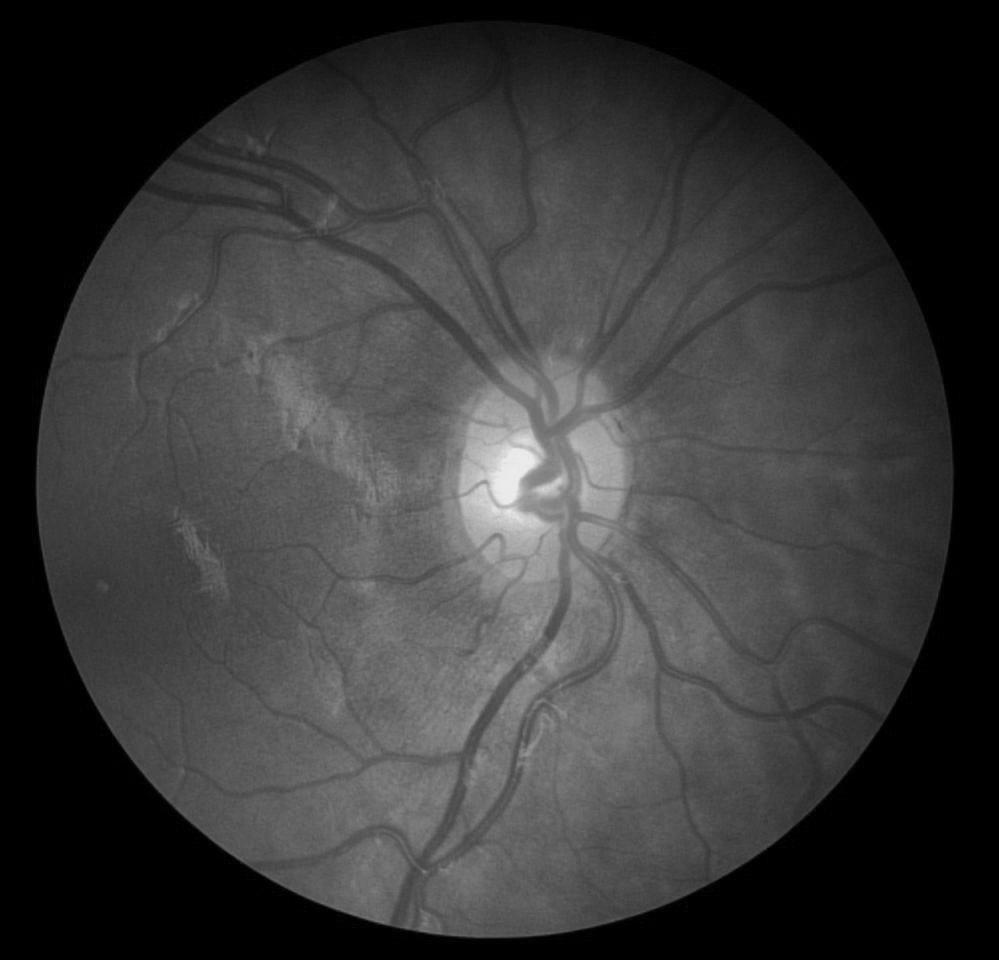

In [2]:
img = Image.open('../../data/raw/CHASEDB1/Image_03R.jpg')
Y, _, _ = img.convert('YCbCr').split()
Y

In [3]:
pad_width = 3
arr = np.array(Y)
arr = np.pad(arr, pad_width=pad_width, mode='reflect')

In [4]:
# Central difference stamps
# Use standard sobel filter for deriv_1
deriv_1 = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
# Compute others by convolution.
deriv_2 = signal.convolve2d(deriv_1, deriv_1)
deriv_xy = signal.convolve2d(deriv_1, deriv_1.T)

# Normalize operators
deriv_1 = deriv_1 / np.count_nonzero(deriv_1)
deriv_2 = deriv_2 / np.count_nonzero(deriv_2)
deriv_xy = deriv_xy / np.count_nonzero(deriv_xy)

img_dx = ndimage.convolve(arr, deriv_1,)
img_dxx = ndimage.convolve(arr, deriv_2)

img_dy = ndimage.convolve(arr, deriv_1.T)
img_dyy = ndimage.convolve(arr, deriv_2.T)

img_dxy = ndimage.convolve(arr, deriv_xy)

curvature = (img_dxx * img_dy**2 + img_dyy * img_dx**2 - 2 * img_dxy * img_dx * img_dy) / \
    (img_dx**2 + img_dy**2)**(1.5)
curvature[np.isnan(curvature)] = 255.0

# Remove padding
curvature = curvature[pad_width:-pad_width, pad_width:-pad_width]

/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


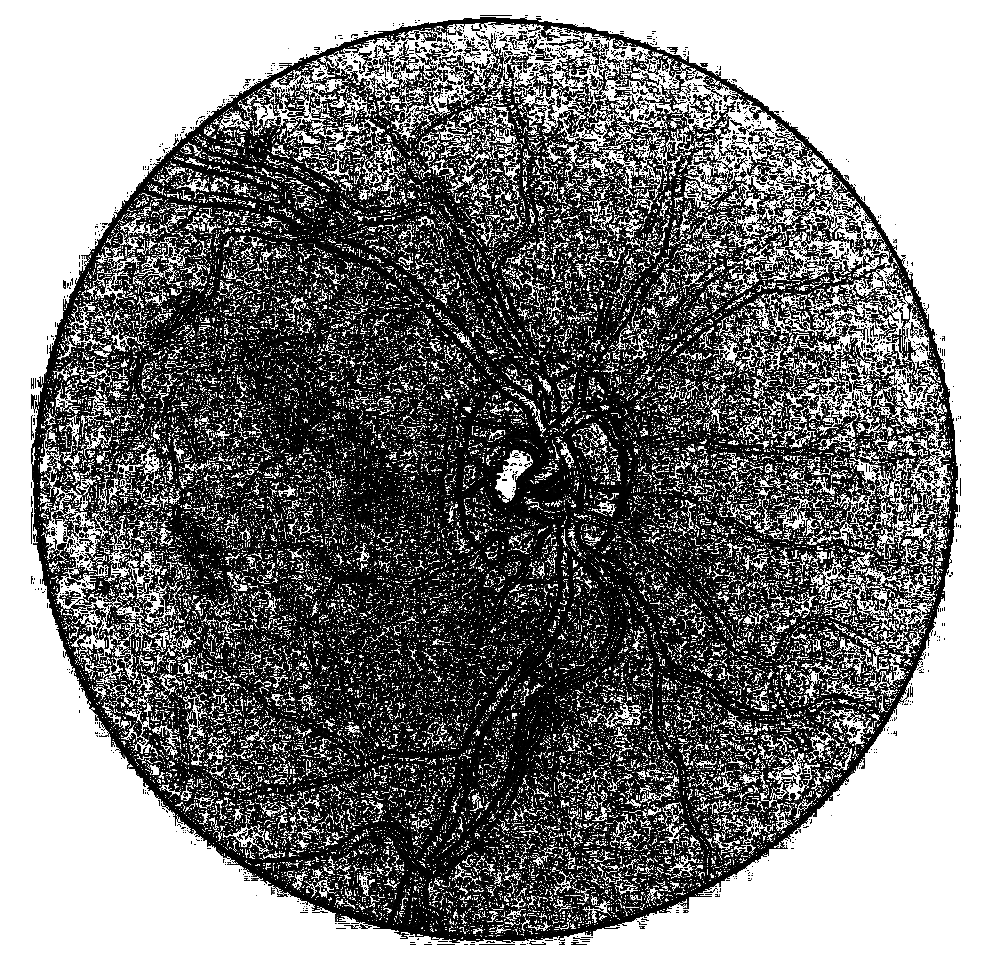

In [5]:
Image.fromarray(curvature).convert('RGB')

In [6]:
# TODO: Use better bins
hist, bins = np.histogram(arr, bins=8)
probabilities = hist/hist.sum()

@jit
def entropy(arr, probabilities, bins):
    # Exclude center from array!
    idx = np.ones(49, bool)
    idx[49//2] = False
    
    entr = np.zeros_like(arr)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            img_window = arr[i-3:i+1+3, j-3:j+1+3].flatten()

            # Boundary condition
            if len(img_window) < 49:
                continue
                
            # All neighbours exist
            #img_center = img_window[49//2]
            p = probabilities[np.digitize(img_window[idx], bins)]
            log_p = np.log(p)
           
            entr[i][j] = -1 * (log_p * p).sum()
            
    # Remove padding
    entr = entr[pad_width:-pad_width, pad_width:-pad_width]
    
    # Smooth a bit
    entr = ndimage.gaussian_filter(entr, 0.5, truncate=3)
    
    # Normalize to [0, 1]
    return entr/np.max(entr)

entr = entropy(arr, probabilities, bins)

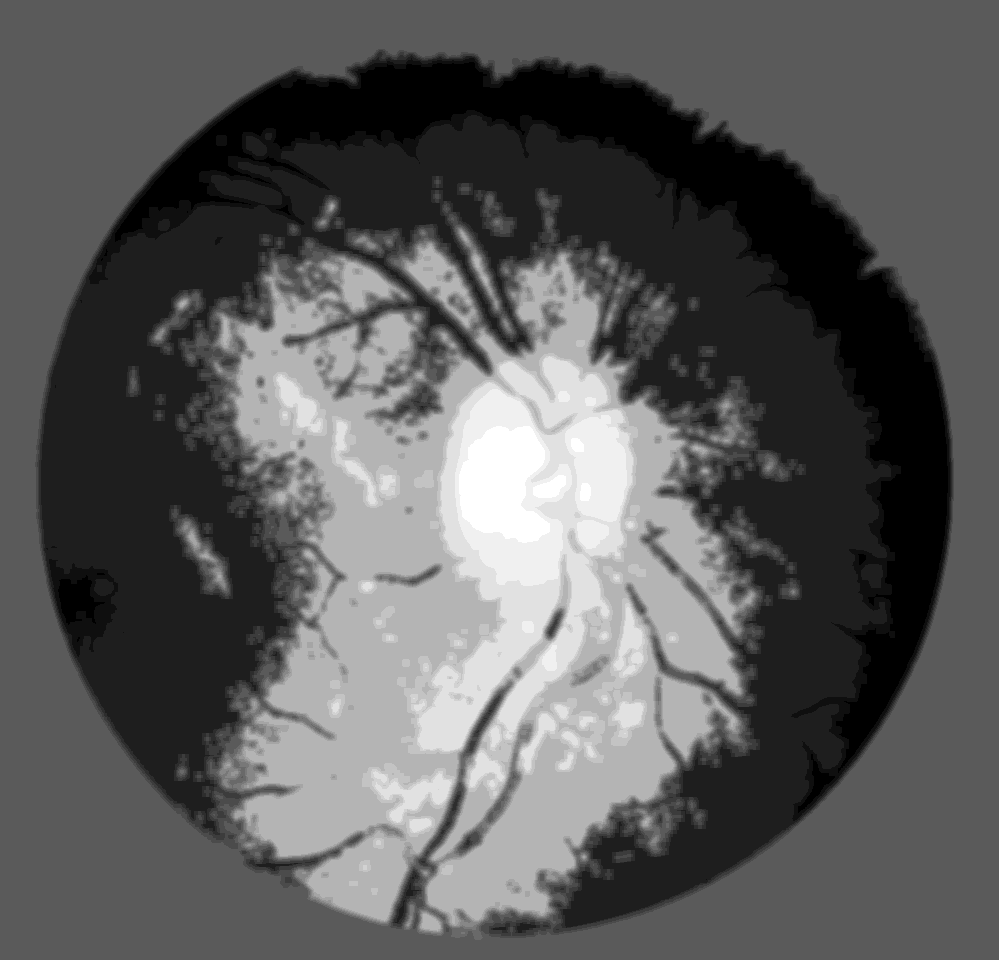

In [7]:
Image.fromarray((1-entr)*255).convert('RGB')

In [64]:
#Image.fromarray(uniqueness).convert('RGB')
@jit()
def uniqueness(arr, feature_map):
    # Pad
    feature_map = np.pad(feature_map, pad_width=pad_width, mode='median') # Maybe reflect?
    
    # Exclude center from array!
    idx = np.ones(9, bool)
    idx[4] = False
    
    res = np.zeros_like(arr)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            img_window = arr[i-1:i+1+1, j-1:j+1+1].flatten()/arr.max()
            feature_window = feature_map[i-1:i+1+1, j-1:j+1+1].flatten()*255.0
            
            # Taken care of by padding!
            if len(feature_window) < 9:
                continue
                
            # All neighbours exist
            img_center = img_window[4]
            feature_center = feature_window[4]
            
            #print(img_window.shape, feature_window.shape)
            img_dist = np.exp(-1 * np.abs(img_center - img_window[idx]))
            #img_dist = np.ones(8)
            feature_dist = np.abs(feature_center - feature_window[idx])
            #print(img_dist.shape, feature_dist.shape)
            
            res[i][j] = (np.multiply(img_dist, feature_dist)).sum()
    
    # Remove padding
    res = res[pad_width:-pad_width, pad_width:-pad_width]
    return res/255.0
            
uniq = uniqueness(arr, 1.0-entr)

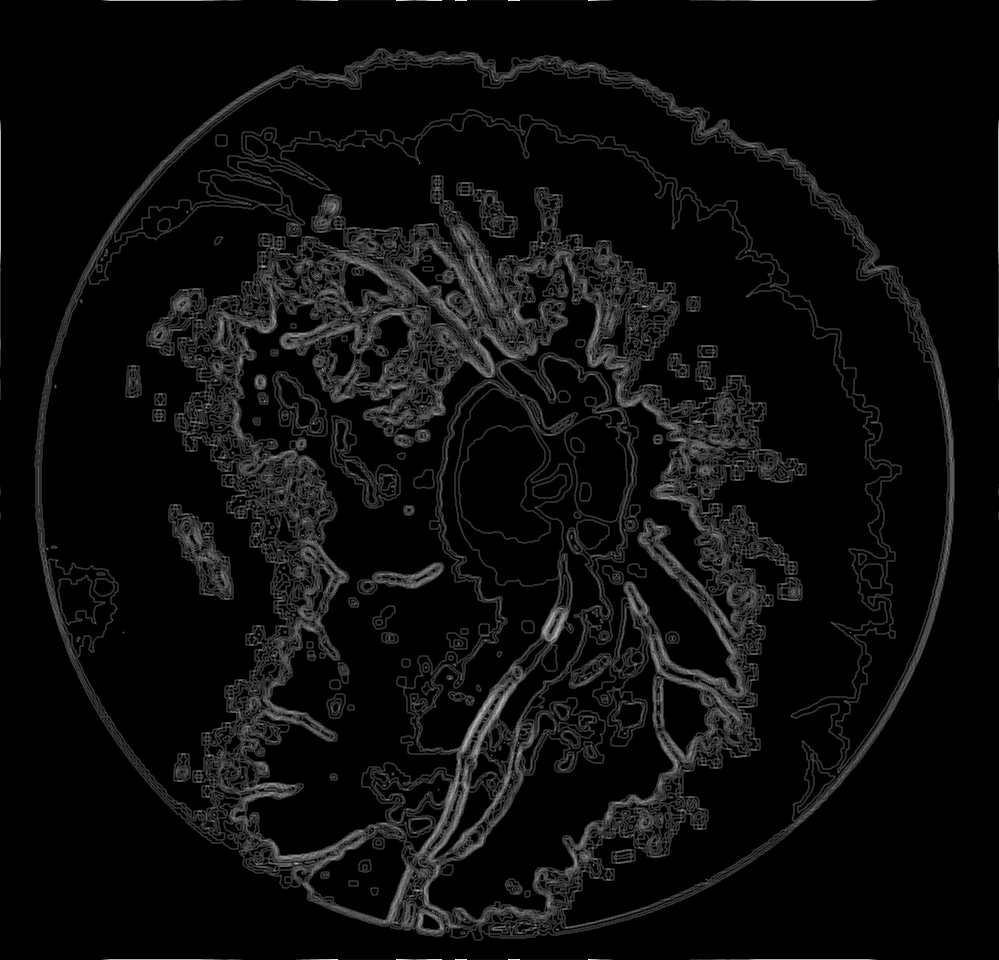

In [65]:
Image.fromarray(uniq*255).convert('RGB')

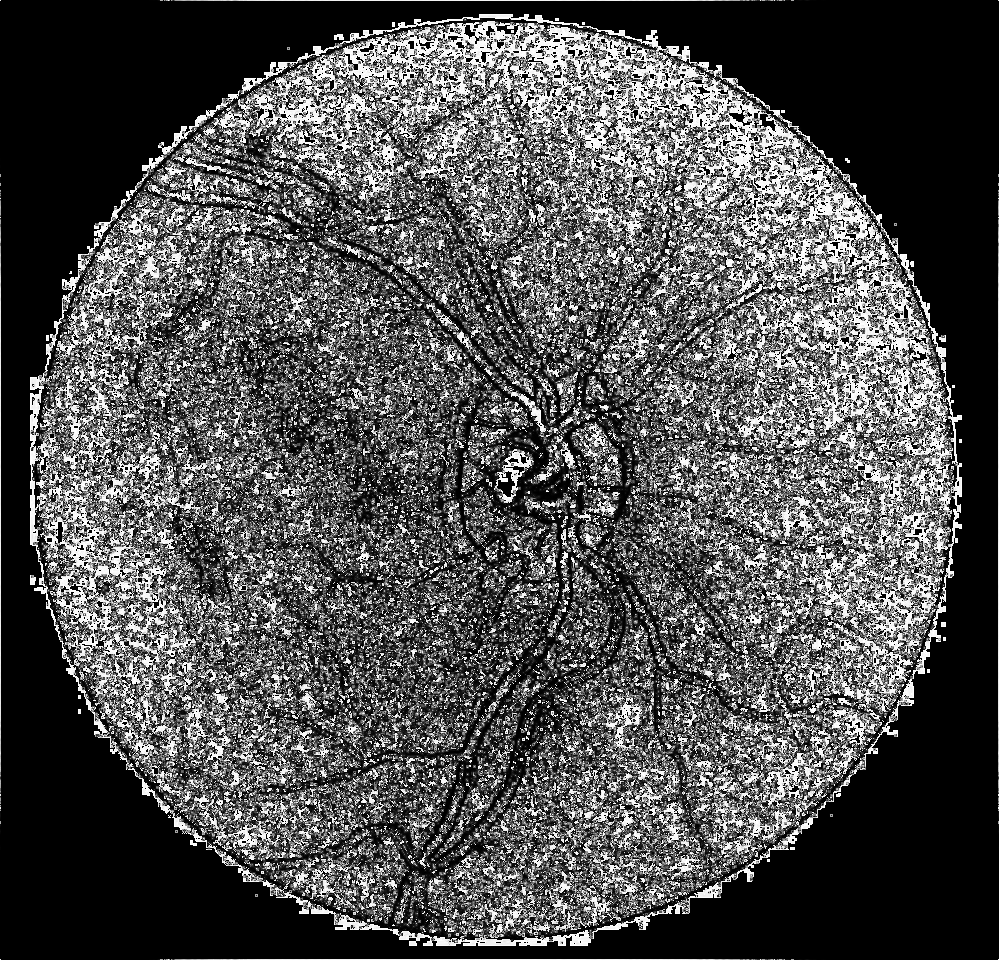

In [10]:
#Image.fromarray(uniq).convert('RGB')
Image.fromarray(uniqueness(arr, curvature/255.0)*255).convert('RGB')

In [11]:
uniq.min(), uniq.max(), curvature.min(), curvature.max()/255

(0.0, 0.99607843137254903, 0.0, 1.0)

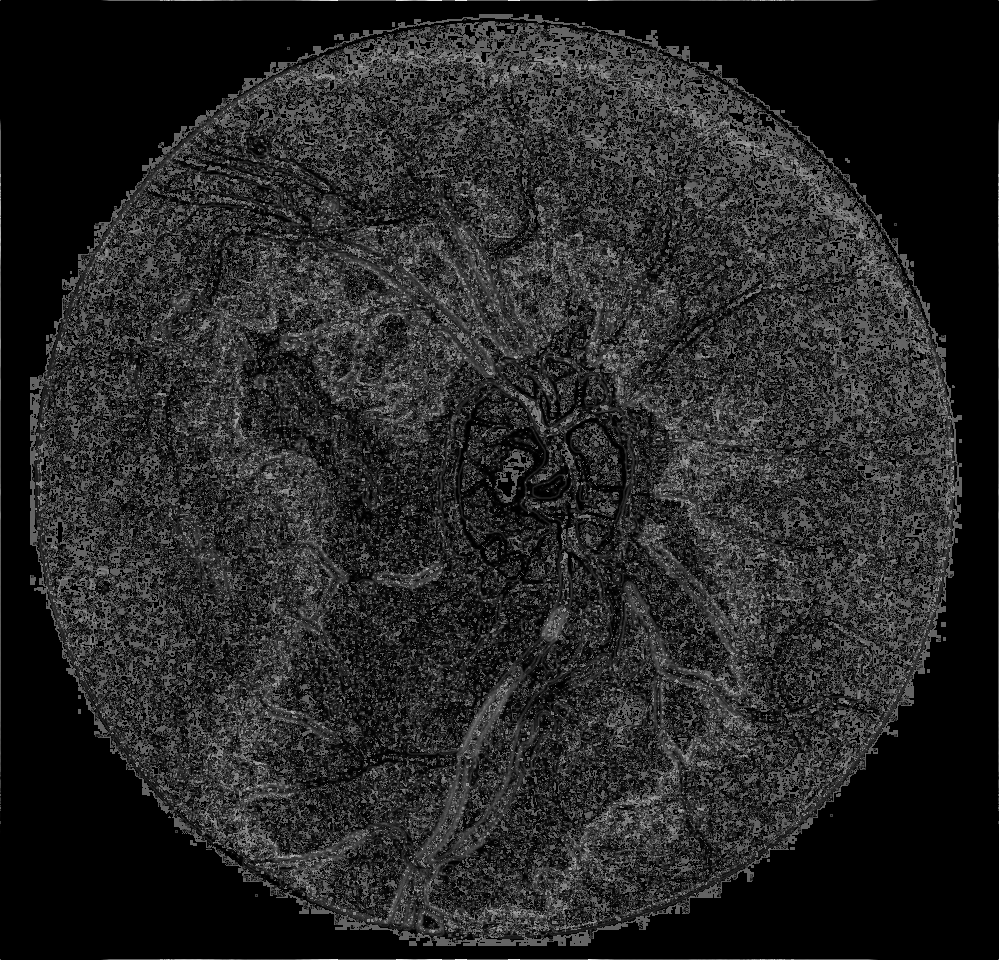

In [66]:
sal = 0.4 *  uniqueness(arr, curvature/255.0) + (0.6 *  uniqueness(arr, 1.0-entr))
Image.fromarray(sal*255).convert('RGB')

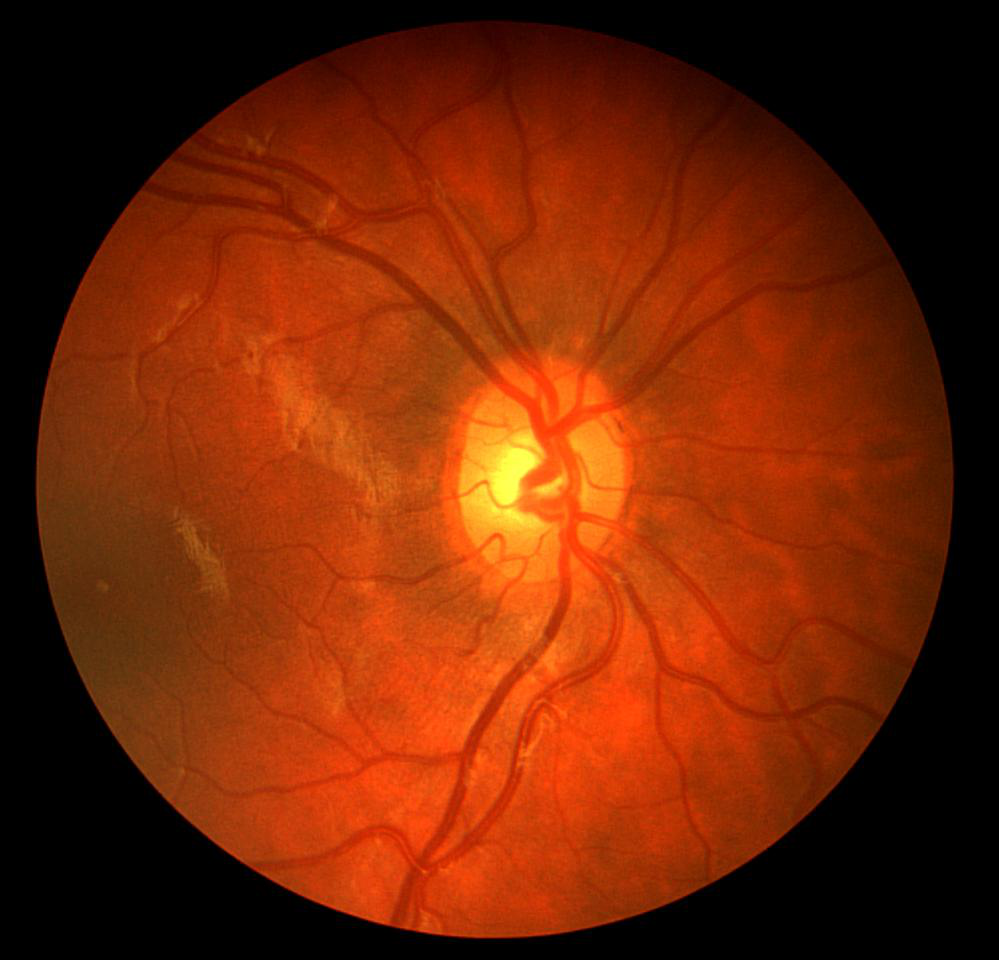

In [61]:
img

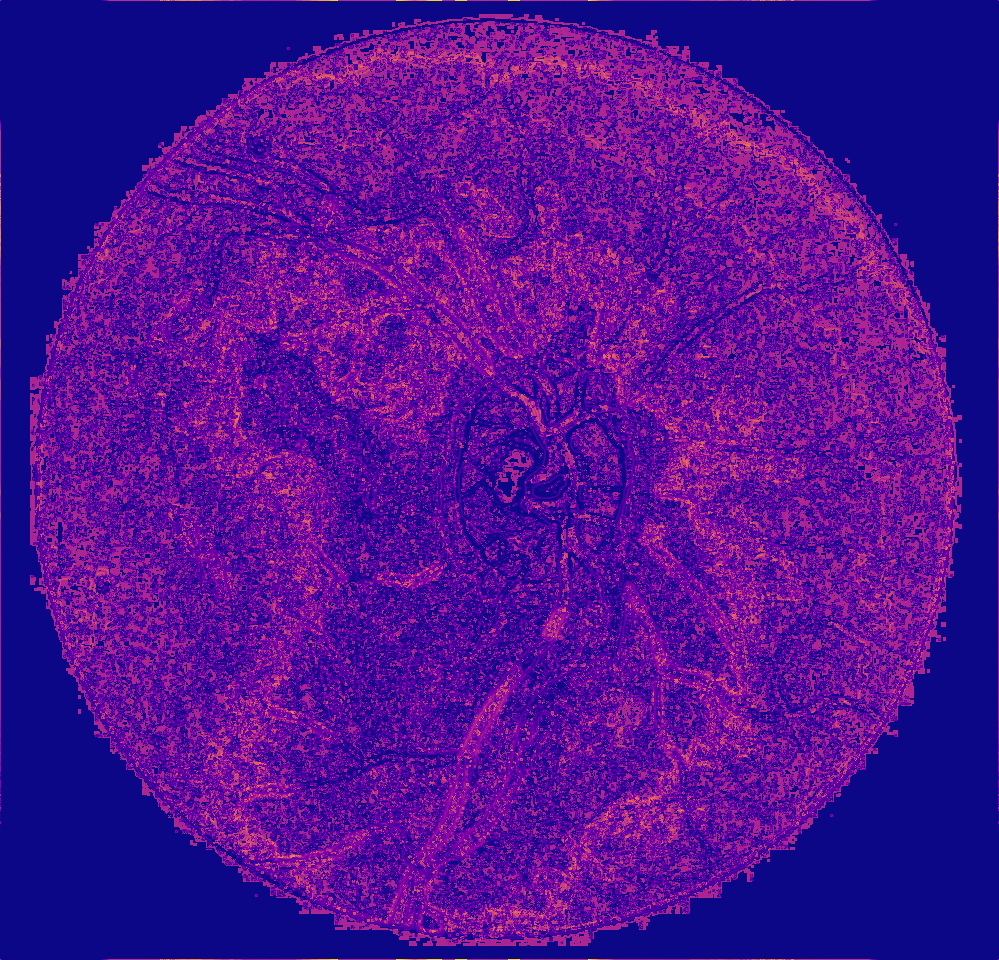

In [62]:
Image.fromarray(np.uint8(cm.plasma(sal)*255))

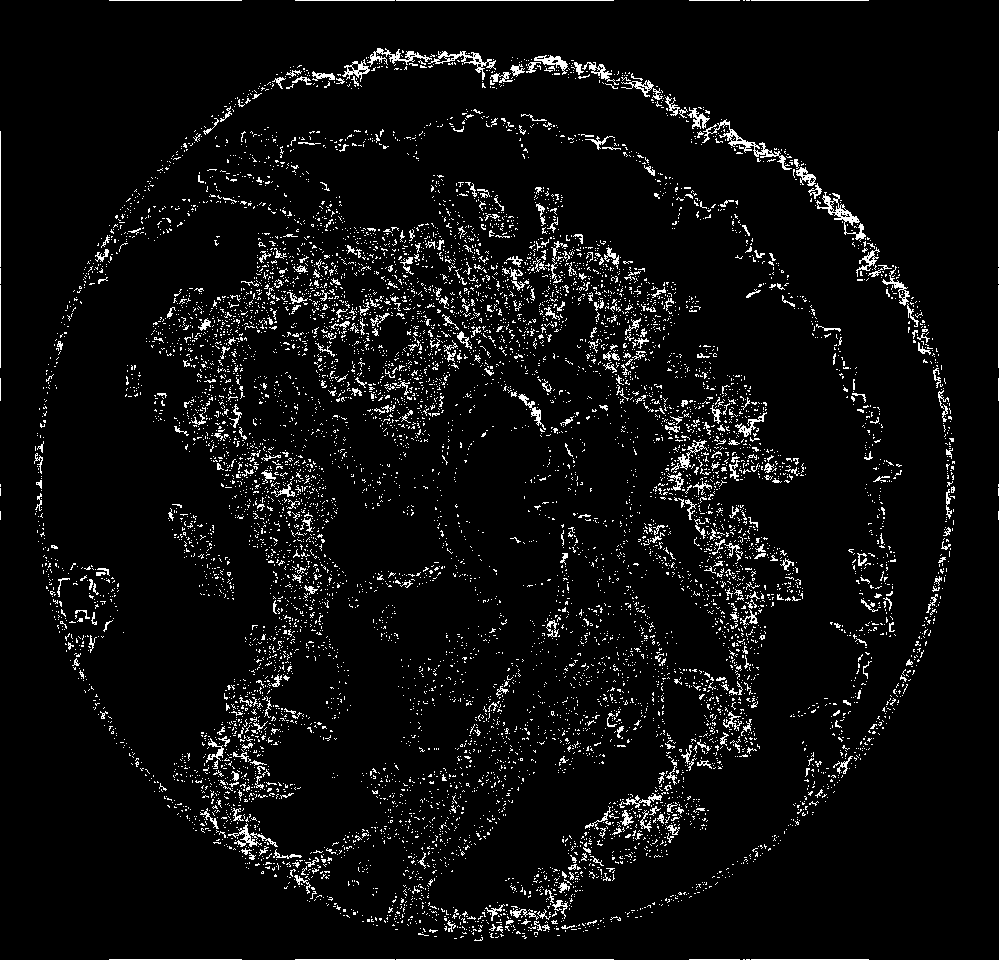

In [63]:
Image.fromarray(np.uint8( (sal>0.4) *255))